In [403]:
# look for sequence inserted in transMap of AugustusPB back to human
from tools.psl import *
from tools.transcripts import *
import os
import pandas as pd
from cat.consensus import *
from tools.fileOps import *
from tools.sqlInterface import *
from tools.nameConversions import strip_alignment_numbers
data_dir = '/public/groups/cgl/cat/primates_evan/rhesus_reverse/work/transMap'

In [38]:
alns = get_alignment_dict(os.path.join(data_dir, 'Human.filtered.psl'))

In [33]:
txs = get_gene_pred_dict(os.path.join(data_dir, 'Human.filtered.gp'))

In [212]:
ref_txs = get_gene_pred_dict('/public/groups/cgl/cat/primates_evan/rhesus_reverse/work/reference/Rhesus.gp')

In [113]:
ref_df = load_annotation('/public/groups/cgl/cat/primates_evan/rhesus_reverse/out/databases/Rhesus.db')

In [ ]:
# filter for 1-1 mappings
unique = set(tm_eval_df[tm_eval_df.UnfilteredParalogy == ''].TranscriptId)

In [199]:
# filter for novel *isoform* predictions
novel = set(ref_df[(ref_df.TranscriptBiotype == 'unknown_likely_coding') & (ref_df.GeneBiotype != 'unknown_likely_coding')].TranscriptId)

In [200]:
useful_ids = novel & unique
print(len(useful_ids))

4951


In [397]:
def convert_ref_chrom(ref_tx, left_pos, right_pos):
    if ref_tx.strand == '+':
        rhesus_right_chrom = ref_tx.mrna_coordinate_to_chromosome(right_pos)
        rhesus_left_chrom = ref_tx.mrna_coordinate_to_chromosome(left_pos)
    else:
        rhesus_right_chrom = ref_tx.mrna_coordinate_to_chromosome(left_pos) + 1
        rhesus_left_chrom = ref_tx.mrna_coordinate_to_chromosome(right_pos - 1)
    assert rhesus_right_chrom > rhesus_left_chrom
    return rhesus_left_chrom, rhesus_right_chrom


def find_exons(ref_tx, rhesus_left_chrom, rhesus_right_chrom):
    i = ChromosomeInterval(ref_tx.chromosome, rhesus_left_chrom, rhesus_right_chrom, ref_tx.strand)
    intersections = []
    for exon in ref_tx.exon_intervals:
        if exon.overlap(i):
            intersections.append(exon)
    return intersections


def convert_back_to_tx(ref_tx, exon):
    # convert to tx coordinates
    left_pos = ref_tx.chromosome_coordinate_to_mrna(exon.start)
    right_pos = ref_tx.chromosome_coordinate_to_mrna(exon.stop - 1)
    if right_pos < left_pos:
        right_pos, left_pos = left_pos, right_pos
    return left_pos, right_pos

def find_indels(aln, tx, ref_tx, min_size=30):
    # remember where we were last iteration
    q_pos = 0
    t_pos = 0
    # iterate over block starts[i], q_starts[i + 1], t_starts[i + 1]
    for block_size, q_start, t_start in zip(*[aln.block_sizes, aln.q_starts[1:], aln.t_starts[1:]]):
        q_offset = q_start - block_size - q_pos
        t_offset = t_start - block_size - t_pos
        if q_offset != 0:  # query insertion -> insertion in target sequence
            if tx.strand == '+':
                left_pos = q_start - q_offset
                right_pos = q_start
                right_chrom = aln.query_coordinate_to_target(right_pos + 1)
                left_chrom = aln.query_coordinate_to_target(left_pos - 1)
            else:
                left_pos = aln.q_size - q_start
                right_pos = aln.q_size - q_start + q_offset
                right_chrom = aln.query_coordinate_to_target(left_pos - 1)
                left_chrom = aln.query_coordinate_to_target(right_pos + 1)
            if left_chrom is None or right_chrom is None:
                continue
            assert left_chrom < right_chrom
            assert left_pos < right_pos
            size = right_pos - left_pos
            if size >= min_size:
                rhesus_left_chrom, rhesus_right_chrom = convert_ref_chrom(ref_tx, left_pos, right_pos)
                for exon in find_exons(ref_tx, rhesus_left_chrom, rhesus_right_chrom):
                    exon_left_pos, exon_right_pos = convert_back_to_tx(ref_tx, exon)
                    yield tx.chromosome, left_chrom, right_chrom, tx.name, exon_left_pos, exon_right_pos, len(exon), exon.chromosome, exon.start, exon.stop
        q_pos = q_start
        t_pos = t_start

In [398]:
r = []
for aln_id, tx in txs.items():
    if strip_alignment_numbers(aln_id) not in useful_ids:
        continue
    aln = alns[aln_id]
    ref_tx = ref_txs[strip_alignment_numbers(aln_id)]
    r.extend(find_indels(aln, tx, ref_tx))

In [399]:
rdf = pd.DataFrame(r, columns=['chromosome', 'chrom_start', 'chrom_stop', 'aln_id', 'start', 'stop', 'size',
                              'rhesus_chromosome', 'rhesus_chrom_start', 'rhesus_chrom_stop'])

In [402]:
# due to alignment issues, it may be the case that these exons exist already in transMap. Remove these
!mkdir -p bam_tmp
rdf[['rhesus_chromosome', 'rhesus_chrom_start', 'rhesus_chrom_stop']].to_csv('bam_tmp/exons.bed', header=None, index=None, sep='\t')

In [452]:
# grab CAT consensus transcripts that are not novel
rhesus_cat_df = pd.read_csv('/public/groups/cgl/cat/primates_evan/out/consensus_gene_set/Rhesus.gp_info', sep='\t')
to_keep = set(rhesus_cat_df[rhesus_cat_df.transcript_biotype != 'unknown_likely_coding'].transcript_id)
with open('bam_tmp/rhesus_cat_exons.bed', 'w') as fh:
    for tx in gene_pred_iterator('/public/groups/cgl/cat/primates_evan/out/consensus_gene_set/Rhesus.gp'):
        if tx.name in to_keep:
            for exon in tx.exon_intervals:
                fh.write('\t'.join(map(str, [tx.chromosome, tx.start, tx.stop])) + '\n')

In [453]:
!bedtools intersect -v -a bam_tmp/exons.bed -b bam_tmp/rhesus_cat_exons.bed > bam_tmp/exons_filtered_for_cat_consensus.bed

In [ ]:
# filter for IsoSeq support
!samtools merge bam_tmp/merged.bam /public/groups/cgl/cat/primates_evan/out/assemblyHub/Rhesus/*bam
!bedtools bamtobed -split -i bam_tmp/merged.bam > bam_tmp/merged.bed
!bedSort bam_tmp/merged.bed bam_tmp/merged.bed
!bedtools merge -i bam_tmp/merged.bed -c 1 -o count > bam_tmp/collapsed.bed

In [172]:
with open('bam_tmp/filtered.bed', 'w') as fh:
    for l in open('bam_tmp/collapsed.bed'):
        l = l.split()
        if int(l[-1]) > 3:
            fh.write('\t'.join(l) + '\n')

In [426]:
!bedtools intersect -u -a bam_tmp/exons.bed -b bam_tmp/collapsed.bed > bam_tmp/exons_filtered_for_isoseq.bed

In [465]:
m = rdf.copy()
for bed, col in [['bam_tmp/exons_filtered_for_cat_consensus.bed', 'cat_consensus_filter'],
                ['bam_tmp/exons_filtered_for_isoseq.bed', 'isoseq_filter']]:
    tmp_df = pd.read_csv(bed, sep='\t', header=None)
    tmp_df.columns = ['rhesus_chromosome', 'rhesus_chrom_start', 'rhesus_chrom_stop']
    tmp_df[col] = [True] * len(tmp_df)
    m = m.merge(tmp_df, on=['rhesus_chromosome', 'rhesus_chrom_start', 'rhesus_chrom_stop'], how='left').drop_duplicates()
m = m.fillna(False)
# flip the consensus to
m['cat_consensus_filter'] = [not x for x in m['cat_consensus_filter']]

In [466]:
m.columns = ['GRCh38 chromosome', 'GRCh38 nearest start', 'GRCh38 nearest stop', 'CAT Alignment ID', 'CAT transcript coordinates exon start',
            'CAT transcript coordinates exon stop', 'exon size',
             'RheMac10 chromosome', 'RheMac10 start', 'RheMac10 stop',
            'Possible false positive', 'Supported by at least 3 IsoSeq reads']

In [467]:
m.to_csv('rhesus_novel_exons.csv', sep='\t', index=None)
m.to_excel('rhesus_novel_exons.xlsx')

In [470]:
m[['RheMac10 chromosome', 'RheMac10 start', 'RheMac10 stop']].to_csv('rhesus_unfiltered_novel_exons.bed', sep='\t', header=None, index=None)
m[m['Possible false positive'] == False][['RheMac10 chromosome', 'RheMac10 start', 'RheMac10 stop']].to_csv('rhesus_filtered_novel_exons.bed', sep='\t', header=None, index=None)

In [455]:
Counter(m.cat_consensus_filter)

Counter({False: 355, True: 26})

In [456]:
rdf[rdf.aln_id == 'Rhesus_T0178304-0'], m[m.aln_id == 'Rhesus_T0178304-0']

(    chromosome  chrom_start  chrom_stop             aln_id  start  stop  size  \
 284       chr5    138319372   138325814  Rhesus_T0178304-0    459   557    99   
 
     rhesus_chromosome  rhesus_chrom_start  rhesus_chrom_stop  
 284              chr6           135729230          135729329  ,
     chromosome  chrom_start  chrom_stop             aln_id  start  stop  size  \
 612       chr5    138319372   138325814  Rhesus_T0178304-0    459   557    99   
 
     rhesus_chromosome  rhesus_chrom_start  rhesus_chrom_stop  \
 612              chr6           135729230          135729329   
 
      cat_consensus_filter  isoseq_filter  
 612                 False           True  )

In [238]:
rdf.shape, m.shape

((256, 10), (229, 10))

In [ ]:
!halLiftover /public/groups/cgl/cat/primates_evan/out/assemblyHub/primates_eichler.hal Rhesus bam_tmp/collapsed.bed Human bam_tmp/human.bed

In [121]:
%matplotlib inline
import seaborn as sns

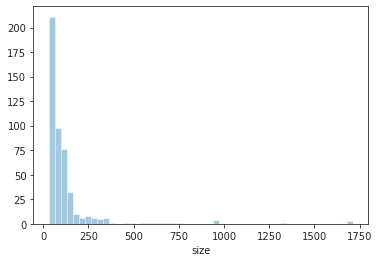

In [134]:
sns.distplot(rdf['size'], kde=False)

In [45]:
# look at original introns
import tools.tm2hints
import tools.nameConversions   
r = []
for aln_id, tx in txs.items():
    aln = alns[aln_id]
    tx_id = tools.nameConversions.strip_alignment_numbers(aln_id)
    ref_aln = ref_alns[tx_id]
    ref_starts = tools.tm2hints.fix_ref_q_starts(ref_aln)
    for i in tx.intron_intervals:
        if not tools.tm2hints.is_fuzzy_intron(i, aln, ref_starts, fuzz_distance=40):
            r.append([aln_id, i])

In [ ]:

tm_eval_df = load_transmap_evals('/public/groups/cgl/cat/primates_evan/rhesus_reverse/out/databases/Human.db')

12238

In [63]:
r = [x for x in r if tools.nameConversions.strip_alignment_numbers(x[0]) in unique]

In [68]:
# filter for primary chromosomes
chroms = {'chr1', 'chr2', 'chr3', 'chr4', 'chr5',
         'chr6', 'chr7', 'chr8', 'chr9', 'chr10',
         'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
         'chr16', 'chr17', 'chr18', 'chr19', 'chr20',
         'chr21', 'chrX'}
r = [x for x in r if x[1].chromosome in chroms]

In [69]:
len(r)

8920

In [94]:
list(unique)[0]

'Rhesus_T0003216'

In [74]:
aln_id = 'Rhesus_T0178304-0'
tx = txs[aln_id]
aln = alns[aln_id]

In [ ]:
# load homGeneMapping vector to figure out if these exons are supported by IsoSeq
# this is done *on the original run*
session = tools.sqlInterface.start_session('/public/groups/cgl/cat/primates_evan/out/databases/Rhesus.db')
intron_table = tools.sqlInterface.tables['hgm']['augPB']
hgm_df = tools.sqlInterface.load_intron_vector(intron_table, session)
intron_table = tools.sqlInterface.tables['hgm']['augCGP']
hgm_df = pd.concat([hgm_df, tools.sqlInterface.load_intron_vector(intron_table, session)])
consensus_df = pd.read_csv('/public/groups/cgl/cat/primates_evan/out/consensus_gene_set/Rhesus.gp_info', sep='\t')
name_map = dict(zip(consensus_df.alignment_id, consensus_df.transcript_id))
hgm_df = hgm_df[['AlignmentId', 'IntronRnaSupport']]
hgm_df['TranscriptId'] = [name_map.get(x) for x in hgm_df.AlignmentId] 
hgm_df = hgm_df[~hgm_df.TranscriptId.isnull()]
hgm_df['IntronRnaSupport'] = [list(map(int, x)) if len(x[0]) > 0 else [] for x in hgm_df['IntronRnaSupport'].str.split(',').tolist()]
intron_vectors = dict(zip(hgm_df.TranscriptId, hgm_df.IntronRnaSupport))

In [347]:
cdc25c = 'Rhesus_T0178304-0'
dnah14 = 'Rhesus_T0005174-0'

In [396]:
aln_id = dnah14
aln = alns[aln_id]
ref_tx = ref_txs[strip_alignment_numbers(aln_id)]
tx = txs[aln_id]
min_size=30
q_pos = 0
t_pos = 0
# iterate over block starts[i], q_starts[i + 1], t_starts[i + 1]
for block_size, q_start, t_start in zip(*[aln.block_sizes, aln.q_starts[1:], aln.t_starts[1:]]):
    q_offset = q_start - block_size - q_pos
    t_offset = t_start - block_size - t_pos
    if q_offset != 0:  # query insertion -> insertion in target sequence
        if tx.strand == '+':
            left_pos = q_start - q_offset
            right_pos = q_start
            right_chrom = aln.query_coordinate_to_target(right_pos + 1)
            left_chrom = aln.query_coordinate_to_target(left_pos - 1)
        else:
            left_pos = aln.q_size - q_start
            right_pos = aln.q_size - q_start + q_offset
            right_chrom = aln.query_coordinate_to_target(left_pos - 1)
            left_chrom = aln.query_coordinate_to_target(right_pos + 1)
        if left_chrom is None or right_chrom is None:
            continue
        assert left_chrom < right_chrom
        assert left_pos < right_pos
        size = right_pos - left_pos
        if size >= min_size:
            rhesus_left_chrom, rhesus_right_chrom = convert_ref_chrom(ref_tx, left_pos, right_pos)
            for exon in find_exons(ref_tx, rhesus_left_chrom, rhesus_right_chrom):
                exon_left_pos, exon_right_pos = convert_back_to_tx(ref_tx, exon)
                print(tx.chromosome, left_chrom, right_chrom, tx.name, exon_left_pos, exon_right_pos, len(exon), exon.chromosome, exon.start, exon.stop)
    q_pos = q_start
    t_pos = t_start

chr1 225043113 225119220 Rhesus_T0005174-0 1507 1697 191 chr1 82570184 82570375
chr1 225043113 225119220 Rhesus_T0005174-0 1698 1943 246 chr1 82573408 82573654
chr1 225043113 225119220 Rhesus_T0005174-0 1944 2065 122 chr1 82585093 82585215


In [373]:
len(ref_tx.exon_intervals), len(tx.exon_intervals)

(64, 61)

In [371]:
left_pos, right_pos

(1507, 2066)

In [375]:
left_chrom, right_chrom

(225043113, 225119220)

In [374]:
ref_tx.mrna_coordinate_to_chromosome(right_pos), ref_tx.mrna_coordinate_to_chromosome(left_pos)

(82608272, 82570184)

In [380]:
i = ChromosomeInterval(ref_tx.chromosome, rhesus_left_chrom, rhesus_right_chrom, ref_tx.strand)

intersections = []
for exon in ref_tx.exon_intervals:
    if exon.overlap(i):
        intersections.append(exon)

In [381]:
intersections

[ChromosomeInterval('chr1', 82570184, 82570375, '+', '{'frame': 1}'),
 ChromosomeInterval('chr1', 82573408, 82573654, '+', '{'frame': 0}'),
 ChromosomeInterval('chr1', 82585093, 82585215, '+', '{'frame': 0}')]

In [353]:
list(find_indels(aln, tx, ref_tx))

[('chr1',
  19587506,
  19589521,
  'Rhesus_T0005174-0',
  346,
  388,
  42,
  'chr1',
  82460212,
  82460254)]

In [358]:
with open('test.psl', 'w') as fh:
    s = alns[dnah14].psl_string()
    s[9] = s[9].split('-')[0]
    fh.write('\t'.join(s) + '\n')
    
!pslPretty test.psl /public/groups/cgl/cat/primates_evan/rhesus_reverse/work/genome_files/Human.2bit /public/groups/cgl/cat/primates_evan/rhesus_reverse/work/reference/Rhesus.2bit /dev/stdout

>Rhesus_T0005174:0+10203 of 10203 chr1:224952747+225399269 of 248956422
ATGGACAAGGAggaaaccaacacaaaaccaag-----2179------acttttaaaatat
|||||||||||||||||||| |||||||||||               |||||||| ||||
ATGGACAAGGAGGAAACCAAGACAAAACCAAGGTAAAA...ATTTAGACTTTTAAGATAT

gaagagaaaaaacaTGAAGATATAAAACCATTAGAGACTCAACCAACTGAAATAGCAGAA
|||||||||||| |||||||| | ||||||||||||||||||||| ||||||||||||||
GAAGAGAAAAAATATGAAGATGTGAAACCATTAGAGACTCAACCAGCTGAAATAGCAGAA

AAGGA---ATTGGAATATAAAACAGTTAAAGCGTTCACTGAATCTTTGAAGTCAGAGAAA
|||||   |||||||||||||||||||| | | ||| |||||||||||||||||||||||
AAGGAAACATTGGAATATAAAACAGTTAGAACATTCTCTGAATCTTTGAAGTCAGAGAAA

ACAGAAG-----9380------AACCAAAAGATGATGATGTGATAAGAAATATTATTAGG
|||||||               ||||||||||||||||||||||||||||||||||||||
ACAGAAGGTATTT...TACCAGAACCAAAAGATGATGATGTGATAAGAAATATTATTAGG

CTACGAGAAAAGCTTGGTTGGCAAACTGTATTACCGCAGCACAGTTTGAAATATGGAAGT
||||||||||||||||||||||||||| ||||||||||||||||||||||||| ||||| 
CTACGAGAAAAGCTTGGTTGGCAAACTATATTACCGCAGCACAGTTTGAAATACGGAAGC

TCCAAAAT